In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm

import torch
import torch.nn as nn

import scipy.ndimage                
def smooth(x, sigma=10):                                             
    return scipy.ndimage.gaussian_filter1d(x, sigma=sigma, axis=0, mode='reflect')

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import NMF
from scipy.cluster.hierarchy import linkage, fcluster

import utils.metropolis as metropolis
from utils.models import FC_Gumbelpredictor

%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.options.display.max_columns = None

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
plt.rcParams['figure.figsize'] = [3, 2]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['svg.fonttype'] = 'none'


# Make groupings and function

Here we consider a simple example with 12 species that are assigned to 3 groups. This assignment is contained in `groupings_ground_truth`.

The function (`fct`) is given by 
\begin{align}
    f(x)=\sum_{i=1}^{3} a_iG_i(x)=\sum_{i=1}^{3} a_i\sum_{j\in I_i}x_j
\end{align}
where $\vec{a}$ is a vector of parameters and $I_i$ is the set of species indices that are in group $i$.
To model the effect of varying environment (either due to perturbation or naturally-occuring), we let the parameter vector $a$ vary across three "regimes":
\begin{align}
    \vec{a}^{(1)}&=(0.1,1,1),\quad\text{when }(G_1>\text{med}(G_1))\,\land\, (G_2>\text{med}(G_2))
    \\
    \vec{a}^{(2)}&=(1,-0.5,-0.1),\quad\text{when }(G_1>\text{med}(G_1))\,\land\, (G_2<\text{med}(G_2))
    \\
    \vec{a}^{(1)}&=(-1,0.1,-1),\quad\text{when }(G_1<\text{med}(G_1))
\end{align}
where $\text{med}(G)$ denotes the median abundance of group $G$.


In [4]:
ngroups = 3
groupings_ground_truth = np.asarray([0,1,1,1,1,0,1,2,2,2,2,2])

def get_groupings(g):
    gmat = np.zeros((len(g), len(np.unique(g))))
    for i in range(len(np.unique(g))):
        gmat[:,i] = g==i

    return gmat

lincoefs = np.asarray([[0.1, 1, 1],
                       [1, -0.5, -0.1],
                       [-1, 0.1, -1]])

def fct(x, groupmat):
    g = x @ groupmat

    reg_1_mask = (g[:,0]>np.median(g[:,0]))*(g[:,2]>np.median(g[:,2]))
    reg_2_mask = (g[:,0]>np.median(g[:,0]))*(g[:,2]<np.median(g[:,2]))
    reg_3_mask = g[:,0]<=np.median(g[:,0])

    outpt = np.zeros(g.shape[0]) # initialize output)

    for i, reg in enumerate([reg_1_mask, reg_2_mask, reg_3_mask]):
        outpt[reg] = np.sum(g[reg,:] * lincoefs[i], axis=1)

    return outpt


def make_data(N, grouping, init_dist={'type': 'normal', 'std': 0.5, 'mu': 0.}, scales=None, y_noise_std=0.0):
    if init_dist['type'] == 'normal':
        x = np.random.normal(loc=init_dist['mu'], scale=init_dist['std'], size=(N, len(grouping)))
    elif init_dist['type'] == 'uniform':
        x = np.random.uniform(low=init_dist['mu']-init_dist['std'], high=init_dist['mu']+init_dist['std'], size=(N, len(grouping)))
    elif init_dist['type'] == 'exp':
        if scales is None:
            scales = init_dist['std']
        else:
            scales = np.asarray(scales)[grouping]*init_dist['std']
        x = np.random.exponential(scale=scales, size=(N, len(grouping)))

    y = fct(x, get_groupings(grouping)) 
    y += np.random.normal(loc=0, scale=y_noise_std, size=y.shape)

    return x, y


## Make a dataset class for our simulated data

In [5]:
from torch.utils.data import Dataset, SubsetRandomSampler

class SimulatedData(Dataset):
    def __init__(self,
                 inputs,
                    targets,
                    batch_size=16, 
                    num_workers=0,
                    device='cuda:0',
                    train_idx=None, # list of indices to use as training set
                    test_idx=None,
                ): 

        super().__init__()

        self.device = torch.device(device)
        
        self.inputs = torch.from_numpy(inputs).float().to(self.device)
        self.targets = torch.from_numpy(targets).float().to(self.device)

        # Make data loaders
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_loader = self.make_loader(indices=train_idx, batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.make_loader(indices=test_idx, batch_size=batch_size, num_workers=num_workers)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'input': self.inputs[idx], 'target': self.targets[idx], 'idx': idx}
    
    def make_loader(self, indices, batch_size, num_workers, pin_memory=False):
        sampler = SubsetRandomSampler(indices)
        loader = torch.utils.data.DataLoader(self, 
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=pin_memory)
        
        return loader
    



## Generate data

In [6]:
xdata, ydata = make_data(1000, 
                         groupings_ground_truth, 
                         init_dist={'type': 'uniform', 'std': 0.3, 'mu': 0.1}, 
                         scales=[1, 1, 1], 
                         y_noise_std=1e-2)

train_idx = np.random.choice(len(xdata), size=int(len(xdata)*0.9), replace=False)
test_idx = np.setdiff1d(np.arange(len(xdata)), train_idx, assume_unique=True) # indices which are not in train_idx

dataset = SimulatedData(xdata, ydata, train_idx=train_idx, test_idx=test_idx, batch_size=len(train_idx))


# Visualize data
### First projected onto single group abundances

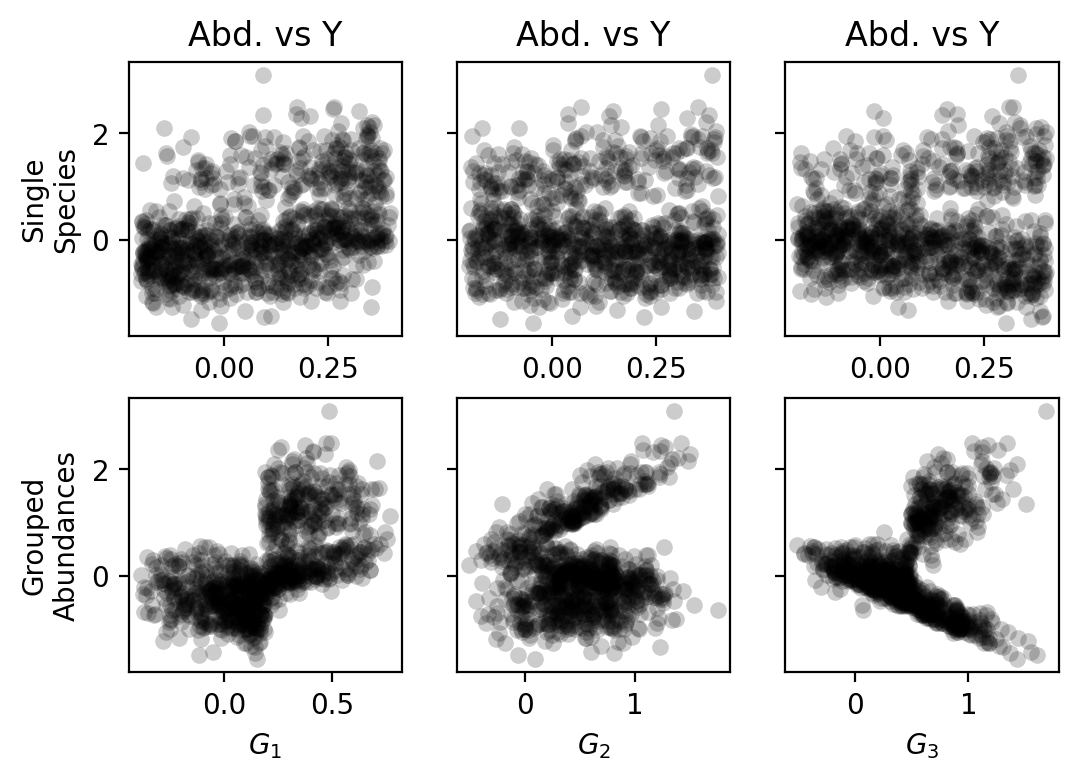

In [7]:
fig,ax=plt.subplots(2,3, figsize=(6, 4))

gp_abd = xdata @ get_groupings(groupings_ground_truth)

for i in range(3):
    idx = i*(len(groupings_ground_truth)//ngroups)
    ax[0][i].scatter(xdata[:,idx], ydata, alpha=0.2, color='k', lw=0)
    ax[0][i].set_xlabel(f'$X_{idx+1}$')
    ax[0][i].set_title(f'Abd. vs Y')
    ax[0][i].set_box_aspect(1)

    ax[1][i].scatter(gp_abd[:,i], ydata, alpha=0.2, color='k', lw=0)
    ax[1][i].set_xlabel(f'$G_{i+1}$')
    ax[1][i].set_box_aspect(1)
    #ax[i].set_yscale('log')

ax[0][0].set_ylabel('Single\nSpecies')
ax[1][0].set_ylabel('Grouped\nAbundances')
for a in ax[:,1:].flat:
    a.set_yticklabels([])


### Now projected onto 2 group abundances

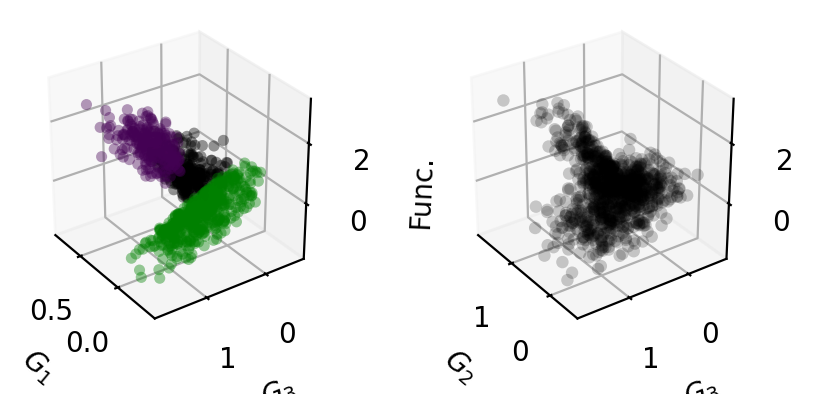

In [8]:
fig,ax=plt.subplots(1,2, figsize=(5,2),dpi=200, subplot_kw={'projection': '3d'})   

gp_abd = xdata @ get_groupings(groupings_ground_truth)

reg_1_mask = (gp_abd[:,0]>np.median(gp_abd[:,0]))*(gp_abd[:,2]>np.median(gp_abd[:,2]))
reg_2_mask = (gp_abd[:,0]>np.median(gp_abd[:,0]))*(gp_abd[:,2]<np.median(gp_abd[:,2]))
reg_3_mask = gp_abd[:,0]<=np.median(gp_abd[:,0])

ax[0].scatter(gp_abd[reg_1_mask,0], gp_abd[reg_1_mask,2], ydata[reg_1_mask], alpha=0.4, c=reg_1_mask[reg_1_mask], lw=0, s=16)
ax[0].scatter(gp_abd[reg_2_mask,0], gp_abd[reg_2_mask,2], ydata[reg_2_mask], alpha=0.4, color='k', lw=0, s=16)
ax[0].scatter(gp_abd[reg_3_mask,0], gp_abd[reg_3_mask,2], ydata[reg_3_mask], alpha=0.4, color='g', lw=0, s=16)
ax[1].scatter(gp_abd[:,1], gp_abd[:,2], ydata, alpha=0.2, color='k', lw=0)

ax[0].set_xlabel('$G_1$')
ax[0].set_ylabel('$G_3$')
ax[0].set_zlabel('Func.')

ax[1].set_xlabel('$G_2$')
ax[1].set_ylabel('$G_3$')
ax[1].set_zlabel('Func.')

for a in ax:
    a.set_box_aspect([1,1,1])
    a.view_init(azim=145, elev=30)


# Make some models to train

In [9]:
# For this data a very small network suffices
act = 'gelu'
nchannels=48 
n_layers = 2
ensemble_size = 6

x = dataset[0]

channel_x_in = x['input'].shape[0]
n_clusters = ngroups
channel_y = 1 # dimension of function prediction
models = []

# Create an ensemble of models
for _ in range(ensemble_size-1):
    models.append( FC_Gumbelpredictor(
                        network_hparams={'inchannel': channel_x_in,
                                            'channels': [n_clusters, *([nchannels,]*n_layers), channel_y], 
                                            'act': act,
                                            'dropout': 0.0,
                                            'dropout_input': 0.0},
                        optimizer_hparams={'LR': 1e-2, 'schedule_rate': 0.999},
                        tau_hparams = {'init': 1.0, 'relax_rate': 0.995, 'min': 0.1}
                        )
                    )

# Train

In [10]:
losses = []

n_steps_total = int(5e3)
pbars = []
for _ in range(len(models)):
    pbars.append( tqdm(total=n_steps_total) )

freq_sample = 10
 
n_epochs = int(np.ceil(n_steps_total))
print(n_epochs)

loss_scale = np.std(dataset.targets.cpu().numpy())**2

count = 0
for e in range(n_epochs):
    for m, (model, pbar) in enumerate(zip(models, pbars)):
        for sample, sample_test in zip(dataset.train_loader, dataset.test_loader):
            if model.isnan: continue
                
            model.optimizer.zero_grad()


            # Cluster and make predictions:
            group_abd = sample['input'] @ model.proj_mat() # cluster
            pred = model(group_abd, None).squeeze() # predict

            loss = torch.nn.functional.mse_loss(pred.squeeze(), sample['target'].squeeze())

            # Test predictions
            with torch.no_grad():
                test_grp_abd = sample_test['input'] @ model.proj_mat()
                test_pred = model(test_grp_abd, None).squeeze()
                test_loss = torch.nn.functional.mse_loss(test_pred.squeeze(), sample_test['target'].squeeze())

            # Backprop and update step
            loss.backward()
            model.optimizer.step()
            model.update_tau()

            # Evaluate entropy of clustering. This step is unnecessary but gives insight into how the clustering evolves during training.
            p = model.deterministic_proj_mat().detach().cpu().numpy()
            row_entropy = -np.sum(p * np.log2(p + 1e-10), axis=1).mean()

            sample_p = model.proj_mat().detach().cpu().numpy()
            sample_ent = -np.sum(sample_p * np.log2(sample_p + 1e-10), axis=1).mean()

            losses.append({'step': count, 
                            'input': m, 
                            'loss': loss.detach().cpu().numpy(), 
                            'test_loss': test_loss.detach().cpu().numpy(),
                            'row_entropy': row_entropy,
                            'sample_entropy': sample_ent,})


            # Print statements for tracking/debugging
            if count==0: print("Input shape: ", group_abd.shape, "Pred and target shape:", pred.shape, sample['target'].shape)

            if e%20 == 0:
                pbar.set_description(f'Loss:\t{(loss.detach().cpu().numpy()/loss_scale):0.4f}' +\
                                    f'\tTest:\t{(test_loss.detach().cpu().numpy()/loss_scale):0.4f}' +\
                                    f'\tTau:\t{model.tau:0.1e}' +\
                                    f'\tEntropy:\t{row_entropy:0.2f} ' +\
                                    f'\tSample ent.:\t{sample_ent:0.2f} ' )
                pbar.update(20)
        count += 1

losses = pd.DataFrame(losses)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

5000
Input shape:  torch.Size([900, 3]) Pred and target shape: torch.Size([900]) torch.Size([900])


# Evaluate model
1. Look at loss to check for evidence of overfitting (increasing test loss)
2. Look at learned clustering matrices
3. Look at predictions

In [11]:
losses.head(5)

,step,input,loss,test_loss,row_entropy,sample_entropy
0,0,0,0.68022186,0.68718916,1.584898,0.906792
1,1,1,0.70195574,0.6914835,1.584898,1.222961
2,2,2,0.7082932,0.70281744,1.584898,1.139370
3,3,3,0.6892501,0.6801665,1.584898,1.223753
4,4,4,0.6930127,0.68602276,1.584898,1.242312


### Look at loss to check for overfitting

Text(0, 0.5, 'Row Entropy')

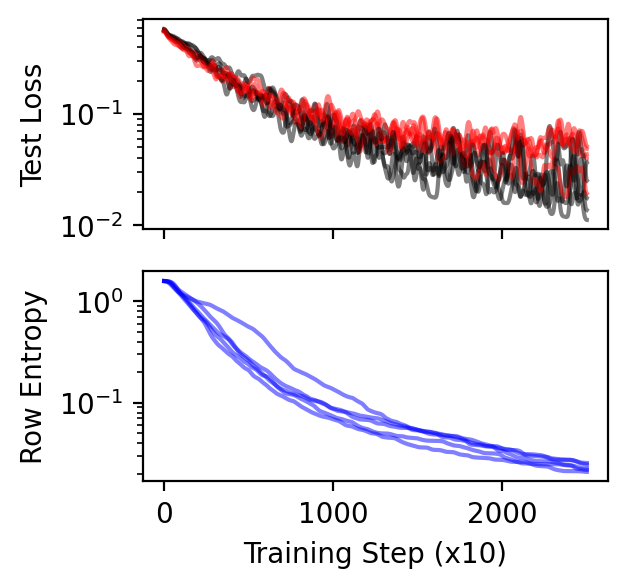

In [12]:
fig,ax=plt.subplots(2,1,figsize=(3,3))

for inpt in range(ensemble_size):
    L_train = np.asarray([x for x in losses[losses.input==inpt].loss.values])
    L_test = np.asarray([x for x in losses[losses.input==inpt].test_loss.values])
    step = losses[losses.input==inpt].step.values
    ax[0].semilogy(step/10, smooth(L_train, sigma=20), label='Train', alpha=0.5, color='k')
    ax[0].semilogy(step/10, smooth(L_test, sigma=20), label='Test', alpha=0.5, color='r')
    ax[1].semilogy(step/10, smooth(losses[losses.input==inpt].row_entropy.values, sigma=20), alpha=0.5, color='b')

ax[0].set_xticklabels([])
ax[0].set_ylabel('Test Loss')
ax[1].set_xlabel('Training Step (x10)')
ax[1].set_ylabel('Row Entropy')

### Look at clustering matrices

[[], []]

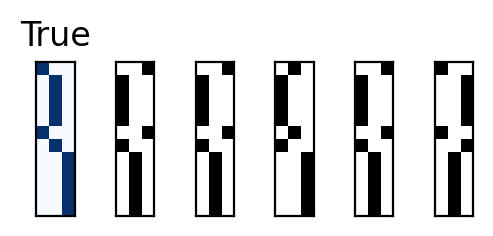

In [13]:
fig,ax=plt.subplots(1,len(models)+1,figsize=(3,1))

ax[0].imshow(get_groupings(groupings_ground_truth), cmap='Blues', vmin=0, vmax=1)
ax[0].set_title('True')
for i,a in enumerate(ax[1:]):
    P = models[i].deterministic_proj_mat().detach().cpu().numpy()
    a.imshow(P, cmap='binary',  vmin=0, vmax=1)
    a.set_xticks([])
    a.set_yticks([])

ax[0].set(xticks=[], yticks=[])

### Compute R2s and predictions on train and test data

In [14]:
# make predictions for whole dataset
R2s_test = []
R2s_train = []

train_preds = []
train_targets = []

test_preds = []
test_targets = []

for m, model in enumerate( models):
    model.eval()

    for sample_train, sample_test in zip(dataset.train_loader, dataset.test_loader):

        with torch.no_grad():
            pred = model(sample_train['input'] @ model.proj_mat(), None).detach().cpu().numpy().squeeze()
            targ = sample_train['target'].detach().cpu().numpy().squeeze()
            train_preds.append(pred)
            train_targets.append(targ)

            test_pred = model(sample_test['input'] @ model.proj_mat(), None).detach().cpu().numpy().squeeze()
            test_targ = sample_test['target'].detach().cpu().numpy().squeeze()
            test_preds.append(test_pred)
            test_targets.append(test_targ)

            R2s_test.append( 1 - np.mean((test_pred - test_targ)**2)/np.var(test_targ))
            R2s_train.append(1 - np.mean((pred - targ)**2)/np.var(targ))            

R2s_test = np.asarray(R2s_test)
R2s_train = np.asarray(R2s_train)

idx_sort = np.argsort(R2s_test)[::-1]

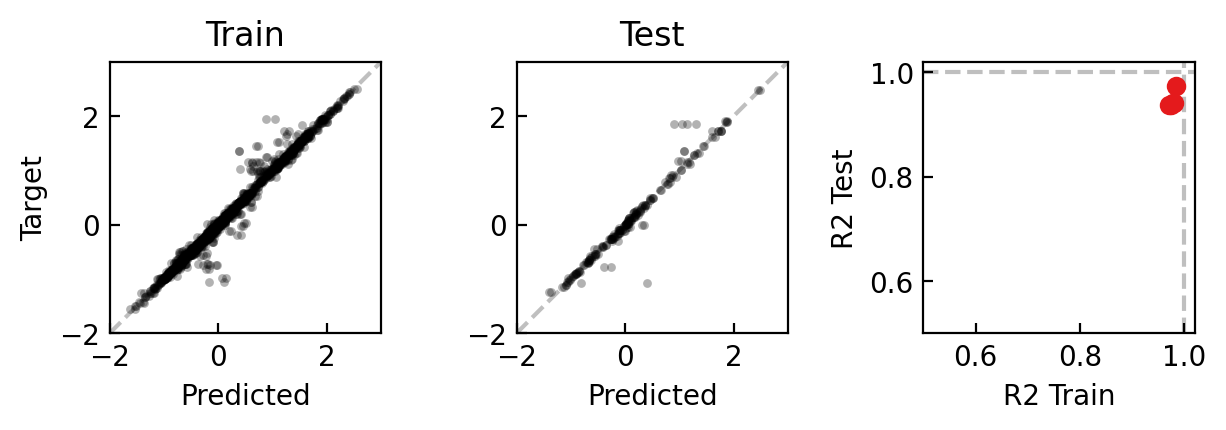

In [15]:
fig,ax=plt.subplots(1,3,figsize=(7,2))

for idx in idx_sort[:2]:
    ax[0].scatter(train_preds[idx], train_targets[idx], label=f'Model {idx}', s=10, lw=0, alpha=0.3, color='k')
    ax[1].scatter(test_preds[idx], test_targets[idx], label=f'Model {idx}', s=10, lw=0, alpha=0.3, color='k')
    
ax[2].scatter(R2s_train, R2s_test)

lim = [-2, 3]
ax[0].plot(lim, lim, color='gray', ls='--', alpha=0.5, zorder=-1)
ax[1].plot(lim, lim, color='gray', ls='--', alpha=0.5, zorder=-1)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)

ax[2].set_xlim(0.5, 1.02)
ax[2].set_ylim(0.5, 1.02)
ax[2].axhline(1, color='gray', ls='--', alpha=0.5, zorder=-1)
ax[2].axvline(1, color='gray', ls='--', alpha=0.5, zorder=-1)

for a in ax:
    a.set_box_aspect(1)
    # ticks in
    a.tick_params(direction='in',)# top=True, right=True)

ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Target')
ax[0].set_title('Train')
ax[1].set_xlabel('Predicted')
ax[1].set_title('Test')
ax[2].set_xlabel('R2 Train')
ax[2].set_ylabel('R2 Test')

fig.subplots_adjust(wspace=0.5)


# Model III: Function-informed, but linear structure-function

We use the monte carlo approach from this paper: Zhao et al. "Linear-regression-based algorithms can succeed at identifying microbial functional groups despite the nonlinearity of ecological function." _PLOS Comp Bio_ (2024)

In [16]:
# Get results of metropolis hastings algorithm
metropolis_results = []

sample_train = next(iter(dataset.train_loader))
sample_test = next(iter(dataset.test_loader))

abundances_train = sample_train['input'].detach().cpu().numpy()
abundances_test = sample_test['input'].detach().cpu().numpy()
target_train = sample_train['target'].detach().cpu().numpy()
target_test = sample_test['target'].detach().cpu().numpy()

def loss_fct_train(grouping):
    return metropolis.compute_regression_loss(grouping, abundances_train, target_train)[0]

def loss_fct_test(grouping):
    return metropolis.compute_regression_loss(grouping, abundances_test, target_test) # returns err, slope, intercept, R2, predictions

pb = tqdm(total=ensemble_size-1)
for _ in range(ensemble_size-1):
    # do metropolis
    metgroupings, loss_hist, groupings_init = metropolis.metropolis(loss_fct_train, n_strains=abundances_train.shape[-1], n_steps=10000, n_groupings=8, max_n_groups=8, min_n_groups=2)

    loss_test = [loss_fct_test(g)[0] for g in metgroupings]
    r2_test = [loss_fct_test(g)[3] for g in metgroupings]

    metropolis_results.append({'groupings': metgroupings, 
                               'loss_hist': loss_hist, 
                               'groupings_init': groupings_init, 
                               'loss_test': loss_test,
                                 'r2_test': r2_test})
    pb.update(1)

metropolis_results = pd.DataFrame(metropolis_results)

metropolis_results.head(3)

  0%|          | 0/5 [00:00<?, ?it/s]

,groupings,loss_hist,groupings_init,loss_test,r2_test
0,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[inf, inf, inf, inf, inf, inf, 0.548080419439...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.4793990565433206, 0.3580400622436782, 0.356...","[0.2951057526248013, 0.47354844203240387, 0.47..."
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0,...","[[inf, inf, inf, inf, 0.5436421589179473, inf,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0,...","[0.5533413767211955, 0.3580400622436782, 0.356...","[0.18638314372611398, 0.47354844203240387, 0.4..."
2,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[inf, inf, 0.5773239347188152, inf, inf, inf,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.5552369641967146, 0.3580400622436782, 0.356...","[0.18359592775509304, 0.47354844203240387, 0.4..."


[[], []]

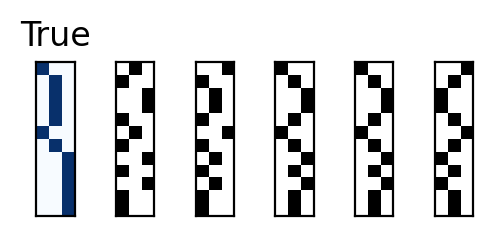

In [17]:
mc_groupings = np.asarray([g[ngroups-1] for g in metropolis_results.groupings.values])


fig,ax=plt.subplots(1,len(models)+1,figsize=(3,1))

ax[0].imshow(get_groupings(groupings_ground_truth), cmap='Blues', vmin=0, vmax=1)

ax[0].set_title('True')
for i,a in enumerate(ax[1:]):
    a.imshow(get_groupings(mc_groupings[i]), cmap='binary',  vmin=0, vmax=1)
    a.set_xticks([])
    a.set_yticks([])

ax[0].set(xticks=[], yticks=[])


# Models I and II: Clustering not function informed
We will generate clusterings with a naive cooccurrence approach where we use correlations between species as the distance matrix for a clustering algorithm (here, `fcluster`). 

In addition we also consider two other approaches to dimensionality reduction: principal component analysis (PCA).

For each of these methods, we will compare two approaches: 
- (Model I) Use the grouped (projected) abundances as the input to linear regression
- (Model II) Use the grouped (projected) abundances as input to a neural network

In total this will give us 4 models: (Coocc, PCA) x (LR, NN)

### Compute projection matrices and grouped/projected abundances

In [18]:
sample_train = next(iter(dataset.train_loader))
sample_test = next(iter(dataset.test_loader))

abundances_train = sample_train['input'].detach().cpu().numpy()
abundances_test = sample_test['input'].detach().cpu().numpy()


### Co-occurrence
co_occurrence = (abundances_train.T @ abundances_train) / abundances_train.shape[0] # covariance matrix
co_occurrence = co_occurrence - np.min(co_occurrence) + 1e-10 # make positive
distance = 1 - co_occurrence/np.max(co_occurrence) # distance matrix
# Make positive
co_occurrence = co_occurrence - np.min(co_occurrence) + 1e-10
Z = linkage(co_occurrence, method='ward')
clusters = fcluster(Z, t=ngroups, criterion='maxclust') # hierarchical clustering with 3 clusters

# Grouping based on clusters
proj_mat_coocc = np.zeros(abundances_train.shape[1])
for i in range(ngroups):
    proj_mat_coocc[clusters == i+1] = i
proj_mat_coocc = get_groupings(proj_mat_coocc)
# Grouped abundances
proj_coocc_train = abundances_train @ proj_mat_coocc
proj_coocc_test = abundances_test @ proj_mat_coocc

### PCA
u, s, vh = np.linalg.svd(abundances_train, full_matrices=False)
proj_mat_pca = vh[:ngroups,:].T
proj_pca_train = u[:,:ngroups] @ np.diag(s[:ngroups])
proj_pca_test = abundances_test @ vh[:ngroups,:].T



### Linear models

In [19]:
lr_pca = LinearRegression()
lr_coocc = LinearRegression()

target_test = sample_test['target'].detach().cpu().numpy()
target_train = sample_train['target'].detach().cpu().numpy()

lr_pca.fit(proj_pca_train, target_train)
lr_coocc.fit(proj_coocc_train, target_train)

# Predictions
pred_pca = lr_pca.predict(proj_pca_train)
pred_co_occurrence = lr_coocc.predict(proj_coocc_train)

# R2s
R2_lr_pca = 1 - np.mean((pred_pca - target_train)**2)/np.var(target_train)
R2_lr_co_occurrence = 1 - np.mean((pred_co_occurrence - target_train)**2)/np.var(target_train)

In [20]:
# Train neural networks for cooccurence and spectral clustering

class FCNN(nn.Module):
    def __init__(self, grouping_mat, channels, act=nn.GELU(), dropout=0.0, device='cuda:0'):
        super(FCNN, self).__init__()
        self.grouping_mat = torch.tensor(grouping_mat, dtype=torch.float32).to(device)
        self.grouping_mat.requires_grad = False  # No gradients for grouping matrix
        layers = []
        for ch, chnext in zip(channels[:-2], channels[1:-1]):
            layers.append(nn.Linear(ch, chnext))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            layers.append(act)
        layers.append(nn.Linear(channels[-2], channels[-1]))  # Output layer
        self.model = nn.Sequential(*layers)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

        self.device = device
        self.to(self.device)

    def forward(self, x):
        x = x @ self.grouping_mat
        return self.model(x)
    

channels = [3, 64, 64, 1]

coocc_models = [FCNN(proj_mat_coocc, channels, dropout=0.1) for _ in range(ensemble_size)]
pca_models = [FCNN(proj_mat_pca, channels, dropout=0.1) for _ in range(ensemble_size)]



In [21]:
losses_function_uninformed = []

n_steps_total = int(2e3)
pbars = []
for _ in range(ensemble_size):
    pbars.append( [tqdm(total=n_steps_total), tqdm(total=n_steps_total)] )

freq_sample = 10
 
n_epochs = int(np.ceil(n_steps_total))
print(n_epochs)

loss_scale = np.std(dataset.targets.cpu().numpy())**2

for model in coocc_models + pca_models:
    model.to(dataset.device)
    model.train()
    model.optimizer.zero_grad()

count = 0
for e in range(n_epochs):
    for m in range(ensemble_size):
        model_coocc, model_pca = coocc_models[m], pca_models[m]

        for sample, sample_test in zip(dataset.train_loader, dataset.test_loader):
                
            model_coocc.optimizer.zero_grad()
            model_pca.optimizer.zero_grad()

            pred_coocc = model_coocc(sample['input']).squeeze()
            pred_pca = model_pca(sample['input']).squeeze()

            if count==0: print("Pred and target shape:", pred_coocc.shape, sample['target'].shape)

            loss_coocc = torch.nn.functional.mse_loss(pred_coocc.squeeze(), sample['target'].squeeze())
            loss_pca = torch.nn.functional.mse_loss(pred_pca.squeeze(), sample['target'].squeeze())

            with torch.no_grad():
                test_pred_coocc = model_coocc(sample_test['input']).squeeze()
                test_pred_pca = model_pca(sample_test['input']).squeeze()
                test_loss_coocc = torch.nn.functional.mse_loss(test_pred_coocc.squeeze(), sample_test['target'].squeeze())
                test_loss_pca = torch.nn.functional.mse_loss(test_pred_pca.squeeze(), sample_test['target'].squeeze())

            loss_coocc.backward()
            model_coocc.optimizer.step()

            loss_pca.backward()
            model_pca.optimizer.step()

            losses_function_uninformed.append({'step': count, 
                            'input': m, 
                            'loss_coocc': loss_coocc.detach().cpu().numpy(), 
                            'test_loss_coocc': test_loss_coocc.detach().cpu().numpy(),
                            'loss_pca': loss_pca.detach().cpu().numpy(), 
                            'test_loss_pca': test_loss_pca.detach().cpu().numpy(),
                            'model': 'cooccurrence' if m < len(coocc_models) else 'spectral',
                        })

            if e%20 == 0:
                pbar = pbars[m][0]
                pbar.set_description(f'Loss:\t{(loss_coocc.detach().cpu().numpy()/loss_scale):0.4f}' +\
                                    f'\tTest:\t{(test_loss_coocc.detach().cpu().numpy()/loss_scale):0.4f}')
                pbar.update(20)
                pbar = pbars[m][1]
                pbar.set_description(f'Loss:\t{(loss_pca.detach().cpu().numpy()/loss_scale):0.4f}' +\
                                    f'\tTest:\t{(test_loss_pca.detach().cpu().numpy()/loss_scale):0.4f}')
                pbar.update(20)
        count += 1

losses_function_uninformed = pd.DataFrame(losses_function_uninformed)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2000
Pred and target shape: torch.Size([900]) torch.Size([900])


Text(0.5, 0, 'Training Step (x10)')

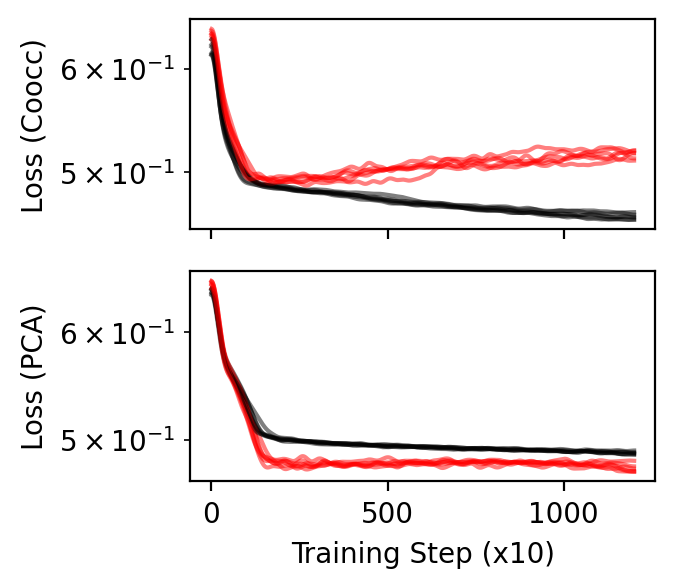

In [22]:
losses_function_uninformed = pd.DataFrame(losses_function_uninformed)

fig,ax=plt.subplots(2,1,figsize=(3,3))

for inpt in range(ensemble_size):
    L_coocc_train = np.asarray([x for x in losses_function_uninformed[losses_function_uninformed.input==inpt].loss_coocc.values])
    L_coocc_test = np.asarray([x for x in losses_function_uninformed[losses_function_uninformed.input==inpt].test_loss_coocc.values])

    L_pca_train = np.asarray([x for x in losses_function_uninformed[losses_function_uninformed.input==inpt].loss_pca.values])
    L_pca_test = np.asarray([x for x in losses_function_uninformed[losses_function_uninformed.input==inpt].test_loss_pca.values])

    step = losses_function_uninformed[losses_function_uninformed.input==inpt].step.values
    ax[0].semilogy(step/10, smooth(L_coocc_train, sigma=20), label='Train Coocc', alpha=0.5, color='k')
    ax[0].semilogy(step/10, smooth(L_coocc_test, sigma=20), label='Test Coocc', alpha=0.5, color='r')

    ax[1].semilogy(step/10, smooth(L_pca_train, sigma=20), label='Train PCA', alpha=0.5, color='k')
    ax[1].semilogy(step/10, smooth(L_pca_test, sigma=20), label='Test PCA', alpha=0.5, color='r')

ax[0].set_xticklabels([])
ax[0].set_ylabel('Loss (Coocc)')
ax[1].set_ylabel('Loss (PCA)')
ax[1].set_xlabel('Training Step (x10)')


### Compute R2 for NN models

In [23]:
R2_nn_pca = []
R2_nn_coocc = []
for m in range(ensemble_size):
    model_coocc, model_pca = coocc_models[m], pca_models[m]

    model_coocc.eval()
    model_pca.eval()

    for sample_train, sample_test in zip(dataset.train_loader, dataset.test_loader):
        with torch.no_grad():
            pred_coocc = model_coocc(sample_test['input']).detach().cpu().numpy().squeeze()
            targ_coocc = sample_test['target'].detach().cpu().numpy().squeeze()
            
            R2_nn_coocc.append( 1 - np.mean((pred_coocc - targ_coocc)**2)/np.var(targ_coocc)) 

            pred_pca = model_pca(sample_test['input']).detach().cpu().numpy().squeeze()
            targ_pca = sample_test['target'].detach().cpu().numpy().squeeze()  

            R2_nn_pca.append( 1 - np.mean((pred_pca - targ_pca)**2)/np.var(targ_pca)) 


R2_nn_pca = np.asarray(R2_nn_pca)
R2_nn_coocc = np.asarray(R2_nn_coocc)

# Plot results: $R^2$ of prediction as well as Jaccard index between the learned groupings and ground truth

In [24]:
def compute_jaccard_index(g1, g2):
    """
    G1 = shape [n_samples, n_groups]
    G2 = shape [n_samples, n_groups] (ground truth)
    Computes the Jaccard index between two groupings.
    """

    dot = np.zeros((ngroups, ngroups))
    for i in range(ngroups):  # corrected variable from n_groups to ngroups
        for j in range(ngroups):  # corrected variable from n_groups to ngroups
            dot[i,j] = np.sum(g1.astype(bool)[:,j] * g2.astype(bool)[:,i])

    union = np.sum(g1.T[np.argmax(dot, axis=1)].T.astype(bool) + g2.astype(bool), axis=0)  # corrected placement of 
    dot = dot / union[:, None]

    return dot, np.max(dot, axis=1)

[0.2        0.28571429 0.28571429] 0.2571428571428571
[1.    0.375 0.375] 0.5833333333333334
[1. 1. 1.] 1.0


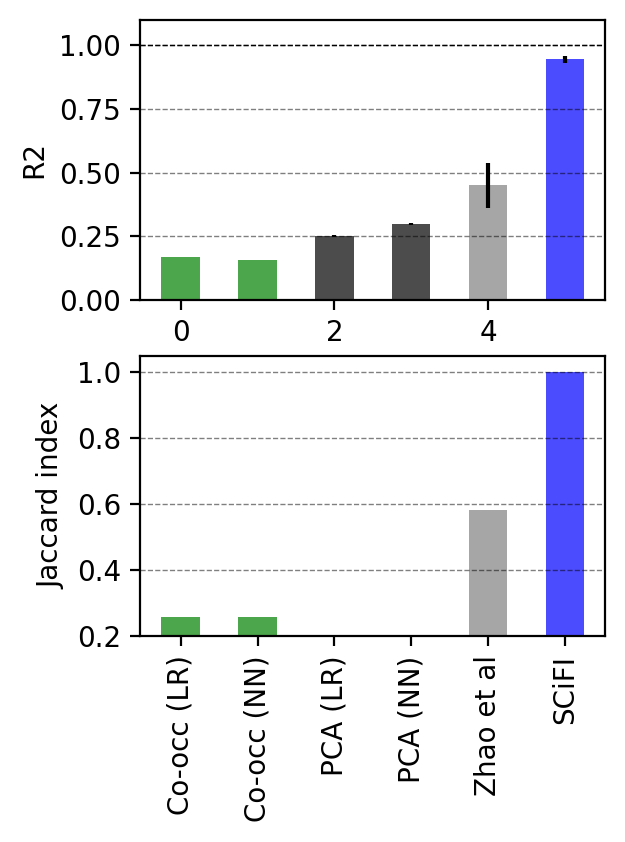

In [25]:

coocc_lr_r2s = np.asarray(R2_lr_co_occurrence)
pca_lr_r2s = np.asarray(R2_lr_pca)

coocc_nn_r2s = np.asarray(R2_nn_coocc)
pca_nn_r2s = np.asarray(R2_nn_pca)

scifi_r2s = np.asarray(R2s_test)
mc_r2s = np.asarray(metropolis_results.r2_test.values.tolist())

means = [coocc_lr_r2s.mean(), pca_lr_r2s.mean(), coocc_nn_r2s.mean(), pca_nn_r2s.mean(), mc_r2s.mean(), scifi_r2s.mean()]
stds = [coocc_lr_r2s.std(), pca_lr_r2s.std(), coocc_nn_r2s.std(), pca_nn_r2s.std(), mc_r2s.std(), scifi_r2s.std()]

# bar plot of R2s
fig, ax = plt.subplots(2, 1, figsize=(3, 4))
ax[0].bar(np.arange(6), means, yerr=stds, color=['g', 'g', 'k', 'k', 'gray', 'b', ], width=0.5, alpha=0.7)
ax[0].set_ylabel('R2')
ax[0].set_ylim(0, 1.1)
ax[0].axhline(1, color='k', lw=0.5, ls='--')



scifi_proj = models[0].deterministic_proj_mat().detach().cpu().numpy() # take first model as representative of scifi results, all are the same
scifi_proj = np.argmax(scifi_proj, axis=1)
scifi_proj = get_groupings(scifi_proj)

metropolis_proj = get_groupings(mc_groupings[0])

ground_truth = get_groupings(groupings_ground_truth)
jaccard_scores = []
for g in [proj_mat_coocc, metropolis_proj, scifi_proj]:
    #print("G shape", g.shape)
    score = compute_jaccard_index(g.astype(bool), ground_truth.astype(bool))[1] 
    print(score, np.mean(score))
    jaccard_scores.append(np.mean(score))

jaccard_scores.insert(1, jaccard_scores[0]) # duplicate cooccurrence score for NN with same grouping
jaccard_scores.insert(2, 0) # add 0 score for PCA clustering which does not produce a grouping
jaccard_scores.insert(2, 0) # add 0 score for PCA clustering which does not produce a grouping


ax[1].bar(np.arange(6), jaccard_scores, color=['g', 'g', 'k', 'k', 'gray', 'b', ], alpha=0.7, width=0.5)
ax[1].set_ylim(0.2,1.05)
ax[1].set_yticks(np.arange(0.2,1.1,0.2));
ax[1].set_xticks(np.arange(6))
ax[1].set_xticklabels(['Co-occ (LR)', 'Co-occ (NN)', 
                       'PCA (LR)', 'PCA (NN)', 
                       'Zhao et al', 'SCiFI'], rotation=90,)

ax[1].set_ylabel('Jaccard index')

for a in ax:
       a.grid(True, axis='y', lw=0.5, ls='--', color='k', alpha=0.5)
